# Replicating the paper "Your Classifier is Secretely an Energy Based Model and you should treat it like one"

Here, I attempt to replicate the paper in the title, by Grathwohl et al.

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sgld_sampler import sgld_sample
from JEM import JEM
from scores import inception_score, frechet_inception_distance
from wrn import create_wide_residual_network

### Classifier for IS/FID

For using IS/FID, we need a classifier. Therefore, we quickly train a classifier for CIFAR-10. We reuse the one from the EBM experiment.

#### Loading the training data

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_train_full.shape, y_train_full.shape

((60000, 28, 28), (60000,))

In [ ]:
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

def vgg_block(layer_in, n_filters, n_conv):
    # Add convolutional layers
    for _ in range(n_conv):
        layer_in = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
    # Add max pooling layer
    layer_in = keras.layers.MaxPooling2D((2,2), strides=(2,2))(layer_in)
    return layer_in

input_ = keras.layers.Input(shape=(28, 28, 1))
vgg_1 = vgg_block(input_, 128, 3) # 14, 14, 128
vgg_2 = vgg_block(vgg_1, 256, 3) # 7, 7, 256
flatten = keras.layers.Flatten()(vgg_2)
output = keras.layers.Dense(10, activation='softmax')(flatten)
model = keras.Model(inputs=input_, outputs=output)
model.summary()

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd", metrics=["accuracy"])
early_stopping = keras.callbacks.EarlyStopping(patience=5, 
                                               restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping])
mnist_classifier = keras.models.load_model('mnist-classifier-1')

We will use this classifier for our experiments.

In [3]:
mnist_classifier = keras.models.load_model('mnist-classifier-1')

## JEM network

I use a wide ResNet with no stochastic regularization, as done in the paper.

In [14]:
ebm_model = create_wide_residual_network((28, 28, 1), nb_classes=10, N=2, k=4)
ebm_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 28, 28, 16)   144         input_2[0][0]                    
__________________________________________________________________________________________________
activation_17 (Activation)      (None, 28, 28, 16)   0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 28, 28, 64)   9216        activation_17[0][0]              
____________________________________________________________________________________________

## Evaluation of network performance

To evaluate the network performance, I use metrics, like the IS and FID. The way these are evaluated is that at every batch, they are applied to the generated and real samples. The metrics are then stored in a list. At the end of an epoch, I look at the mean value for each metric of the current epoch and at the last epoch. If the mean value of the current epoch is higher than the mean value of the last epoch, I conclude that the network learned something and save the weights. If not, I conclude that the network has converged or overfit and stop the learning process. For multiple metrics, I perform a majority vote: If the majority agrees that learning occured, I continue. If not, I stop the learning process.

At the end of the learning process, the ```EBM``` object records the trend for all metrics and the best values achieved. Note that I assume that for all metrics, it holds that a higher value means a better value; therefore I negate the FID to fit in that framework. 

In [6]:
def fuse_images(width, height, images, img_width, img_height):
    really_big_image = None
    for i in range(width):
        big_image = None
        for j in range(height):
            cur_image = images[width * i + j].reshape(img_width, img_height)
            if big_image is not None:
                big_image = np.hstack((big_image, cur_image))
            else:
                big_image = cur_image
        if really_big_image is not None:
            really_big_image = np.vstack((really_big_image, big_image))
        else:
            really_big_image = big_image
    return really_big_image

def is_metric_callback(samples_data, samples_energ, it):
    p_yx = mnist_classifier(samples_energ).numpy()
    score = inception_score(p_yx)
    return score

# Need last-layer activations for FID
mnist_statistics = keras.Model(mnist_classifier.input, mnist_classifier.get_layer(name='flatten').output)

def fid_metric_callback(samples_data, samples_energ, it):
    stats_gen = mnist_statistics(samples_energ)
    stats_real = mnist_statistics(samples_data)
    score = frechet_inception_distance(stats_real, stats_gen)
    return -score

In [7]:
optimizer = keras.optimizers.Adam(1e-4)

In [8]:
jem = JEM(ebm_model, optimizer)

In [ ]:
history = jem.fit(X_train_full, y_train_full, 128, 25, optimizer, 0.0, 1.0, num_steps_markov=tf.constant(120),
        var=tf.constant(1e-2 ** 2), step_size=tf.constant(2.0), callbacks_energy=[],
        metrics_samples=[("IS", is_metric_callback), ("FID", fid_metric_callback)],
        alpha=tf.constant(0.0), clip_thresh=tf.constant(1e6),
        weight_ce_loss=tf.constant(1.0), save_best_weights=True, use_replay_buffer=True)

In [19]:
batch_size = 10
x_init = tf.random.uniform(shape=(batch_size, 28, 28))
imgs = sgld_sample(jem.energy, x_init, tf.constant(1000), 1, 0.001 ** 2, clip_thresh=tf.constant(1.0))

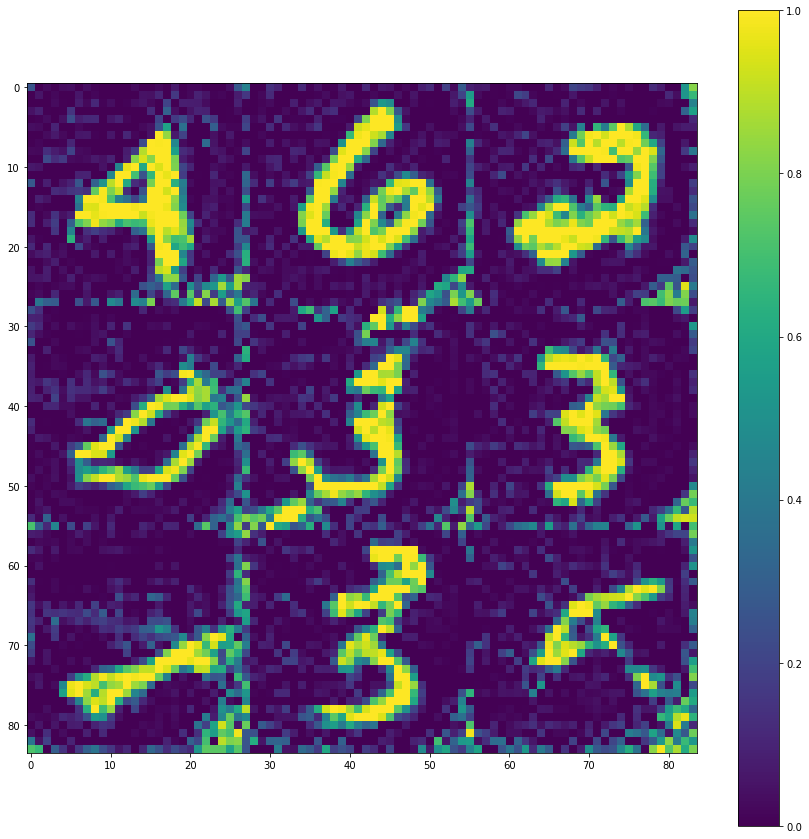

In [20]:
imgs = np.clip(imgs, 0, 1)
img = fuse_images(3, 3, imgs, 28, 28)
plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.colorbar()
plt.show()

## Test set accuracy of the JEM model

In [75]:
preds_test = jem.classify(X_train_full)

In [65]:
y_test_one_hot = tf.keras.backend.one_hot(y_test, 10)

In [67]:
m = tf.keras.metrics.categorical_accuracy(y_test_one_hot, preds_test)

In [68]:
np.mean(m.numpy())

0.9572

## Calibration of the classifier

In [82]:
pred_confidence = np.max(preds_test, axis=1)

In [83]:
pred_confidence

array([0.4682794 , 0.9580364 , 0.9531985 , ..., 0.83769923, 0.8182639 ,
       0.6720254 ], dtype=float32)

In [47]:
def make_thresholds(X, y, performance, thresholds):
    sets = []
    initial = 0.0
    for threshold in thresholds:
        indices = np.logical_and(performance > initial, performance < threshold)
        sets.append((X[indices], y[indices]))
        initial = threshold
    return sets

In [121]:
perf_buckets = make_thresholds(X_train_full, y_train_full, pred_confidence, [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [123]:
y_train = tf.keras.backend.one_hot(y_train_full, 10)

In [124]:
conf_avg = []
for data, labels in perf_buckets:
    preds = jem.classify(data)
    y = tf.keras.backend.one_hot(labels, 10)
    m = tf.keras.metrics.categorical_accuracy(y, preds)
    conf_avg.append(np.mean(m.numpy()))

In [125]:
conf_avg

[0.4,
 0.3619403,
 0.53481483,
 0.6829828,
 0.83304894,
 0.93706435,
 0.9797178,
 0.9947166]

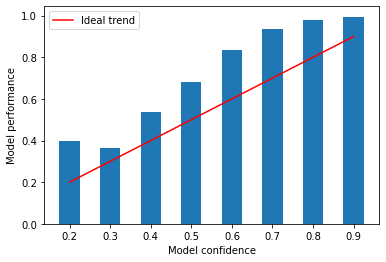

In [135]:
plt.bar([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], conf_avg, width=0.05)
plt.plot(np.linspace(0.2, 0.9, 100),np.linspace(0.2, 0.9, 100), c="red", label="Ideal trend")
plt.ylabel("Model performance")
plt.xlabel("Model confidence")
plt.legend()
plt.show()

## Out-of-distribution detection - using FashionMNIST

### Using likelihood

In [12]:
(X_train_full_fm, y_train_full_fm), (X_test_fm, y_test_fm) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full_fm = X_train_full_fm / 255.0
X_test_fm = X_test_fm / 255.0
X_train_full_fm.shape, y_train_full_fm.shape

((60000, 28, 28), (60000,))

In [312]:
energs_fm = jem.get_likelihoods(X_train_full_fm)
energs_mnist = jem.get_likelihoods(X_train_full)
energ_min_mnist = np.min(-energs_mnist)
energ_min_fm = np.min(-energs_fm)
energ_max_mnist = np.max(-energs_mnist)
energ_max_fm = np.max(-energs_fm)

energ_min = np.minimum(energ_min_mnist, energ_min_fm)
energ_max = np.maximum(energ_max_mnist, energ_max_fm)

In [314]:
energs_mnist_norm = (-energs_mnist - energ_min) / (energ_max - energ_min)
energs_fm_norm = (-energs_fm - energ_min) / (energ_max - energ_min)
combined_energs = np.hstack((energs_mnist_norm, energs_fm_norm))

In [320]:
labels_true = np.ones(energs_mnist_norm.shape[0])
labels_false = np.zeros(energs_fm_norm.shape[0])
labels = np.hstack((labels_true, labels_false))

In [321]:
aucroc = sklearn.metrics.roc_auc_score(labels, combined_energs)

In [322]:
aucroc

0.9738398326388888

In [323]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(labels, combined_energs)

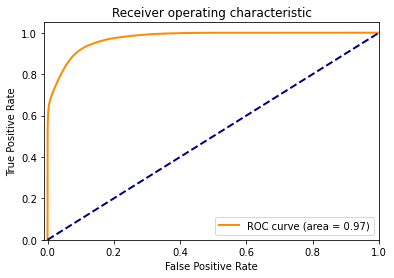

In [324]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % aucroc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig("ROC-MNIST-L")
plt.show()

### Using Gradient Magnitude

In [332]:
energs_fm = jem.get_energ_gradient_magnitudes(X_train_full_fm)
energs_mnist = jem.get_energ_gradient_magnitudes(X_train_full)
energ_min_mnist = np.min(-energs_mnist)
energ_min_fm = np.min(-energs_fm)
energ_max_mnist = np.max(-energs_mnist)
energ_max_fm = np.max(-energs_fm)

energ_min = np.minimum(energ_min_mnist, energ_min_fm)
energ_max = np.maximum(energ_max_mnist, energ_max_fm)

In [335]:
energs_fm_norm = (-energs_fm - energ_min) / (energ_max - energ_min)
energs_mnist_norm = (-energs_mnist - energ_min) / (energ_max - energ_min)
combined_energs = np.hstack((energs_mnist_norm, energs_fm_norm))

In [336]:
labels_true = np.ones(energs_mnist_norm.shape[0])
labels_false = np.zeros(energs_fm_norm.shape[0])
labels = np.hstack((labels_true, labels_false))

In [337]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(labels, combined_energs)

In [338]:
aucroc = sklearn.metrics.roc_auc_score(labels, combined_energs)

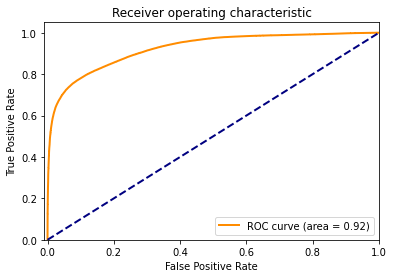

In [339]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % aucroc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig("ROC-MNIST-G")
plt.show()

### Using Confidence

In [344]:
preds_mnist = jem.classify(X_train_full)
pred_confidence_mnist = np.max(preds_mnist, axis=1)
preds_fm = jem.classify(X_train_full_fm)
pred_confidence_fm = np.max(preds_fm, axis=1)

energ_min_mnist = np.min(pred_confidence_mnist)
energ_min_fm = np.min(pred_confidence_fm)
energ_max_mnist = np.max(pred_confidence_mnist)
energ_max_fm = np.max(pred_confidence_fm)

energ_min = np.minimum(energ_min_mnist, energ_min_fm)
energ_max = np.maximum(energ_max_mnist, energ_max_fm)

In [345]:
energs_mnist_norm = (pred_confidence_mnist - energ_min) / (energ_max - energ_min)

In [346]:
energs_fm_norm = (pred_confidence_fm - energ_min) / (energ_max - energ_min)

In [347]:
combined_energs = np.hstack((energs_mnist_norm, energs_fm_norm))

In [348]:
labels_true = np.ones(energs_mnist_norm.shape[0])
labels_false = np.zeros(energs_fm_norm.shape[0])
labels = np.hstack((labels_true, labels_false))

In [349]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(labels, combined_energs)

In [350]:
aucroc = sklearn.metrics.roc_auc_score(labels, combined_energs)

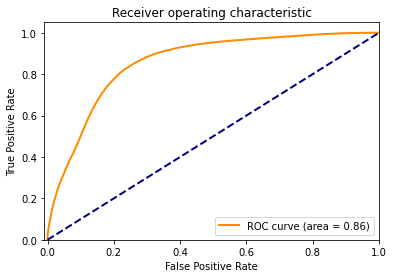

In [351]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % aucroc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig("ROC-MNIST-C")
plt.show()

## FashionMNIST

In [8]:
ebm_model_fm = create_wide_residual_network((28, 28, 1), nb_classes=10, N=2, k=5)
ebm_model_fm.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 16)   144         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 28, 28, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 80)   11520       activation[0][0]                 
____________________________________________________________________________________________

## FashionMNIST Classifier for IS/FID

In [9]:
def vgg_block(layer_in, n_filters, n_conv):
    # Add convolutional layers
    for _ in range(n_conv):
        layer_in = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
    # Add max pooling layer
    layer_in = keras.layers.MaxPooling2D((2,2), strides=(2,2))(layer_in)
    return layer_in

In [10]:
input_ = keras.layers.Input(shape=(28, 28, 1))
vgg_1 = vgg_block(input_, 128, 3) # 14, 14, 128
vgg_2 = vgg_block(vgg_1, 256, 3) # 7, 7, 256
flatten = keras.layers.Flatten(name='flatten')(vgg_2)
output = keras.layers.Dense(10, activation='softmax')(flatten)
model = keras.Model(inputs=input_, outputs=output)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 128)       1280      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 128)       147584    
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 256)       295168    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 256)       5900

In [13]:
X_valid, X_train = X_train_full_fm[:5000], X_train_full_fm[5000:]
y_valid, y_train = y_train_full_fm[:5000], y_train_full_fm[5000:]

In [14]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam", metrics=["accuracy"])
early_stopping = keras.callbacks.EarlyStopping(patience=10, 
                                               restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping])

Epoch 1/10
1719/1719 [==============================] - 31s 9ms/step - loss: 0.5582 - accuracy: 0.7955 - val_loss: 0.2825 - val_accuracy: 0.8968
Epoch 2/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.2651 - accuracy: 0.9024 - val_loss: 0.2474 - val_accuracy: 0.9138
Epoch 3/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2079 - accuracy: 0.9247 - val_loss: 0.2167 - val_accuracy: 0.9186
Epoch 4/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.1736 - accuracy: 0.9372 - val_loss: 0.2083 - val_accuracy: 0.9220
Epoch 5/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.1470 - accuracy: 0.9475 - val_loss: 0.2390 - val_accuracy: 0.9212
Epoch 6/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.1171 - accuracy: 0.9581 - val_loss: 0.2145 - val_accuracy: 0.9278
Epoch 7/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0913 - accuracy: 0.9669 - val_loss: 0.2605 - val_ac

In [19]:
optimizer = keras.optimizers.Adam(1e-4)

In [20]:
jem_fm = JEM(ebm_model_fm, optimizer)

In [ ]:
history_fm = jem_fm.fit(X_train_full_fm, y_train_full_fm, 32, 25, optimizer, 0.0, 1.0, num_steps_markov=tf.constant(120),
        var=tf.constant(1e-2 ** 2), step_size=tf.constant(2.0), callbacks_energy=[],
        metrics_samples=[("IS", is_metric_callback), ("FID", fid_metric_callback)],
        alpha=tf.constant(0.0), clip_thresh=tf.constant(1e6),
        weight_ce_loss=tf.constant(1.0), save_best_weights=True, use_replay_buffer=True)